<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban

Designer: Reza Vahidimajd
</font>
<br>
<br>
<font size=6>
Homework 5
</font><br>
<font size=4>


#Vision Transformer for Brain Tumor Image Classification

In this notebook, we delve into the robust capabilities of Vision Transformers (ViT) for tackling the intricate task of image classification using the Brain Tumor dataset. While traditional Convolutional Neural Networks (CNNs) have long been the standard architecture for image-related tasks, ViT introduces a novel approach by leveraging self-attention mechanisms inspired by the Transformer architecture originally developed for natural language processing.

The Brain Tumor dataset utilized here comprises a collection of brain MRI scans, each meticulously categorized into four distinct classes. Our objective is to design and train a custom ViT model that can accurately classify these MRI scans based on their visual features, demonstrating the effectiveness of Vision Transformers in medical image analysis.

#Vision Transformer

A Vision Transformer (ViT) is a cutting-edge deep learning architecture that adapts the Transformer model—originally designed for sequential data like text—to process image data effectively. This innovative approach begins by dividing an input image into fixed-size patches, which are then linearly embedded into vector representations. These embedded vectors are treated as a sequence and fed into Transformer layers, enabling the ViT to capture both local and global dependencies within the image. By leveraging self-attention mechanisms, Vision Transformers can model complex relationships and patterns, making them highly effective for various image analysis tasks.

#Brain Tumor Dataset

The Brain Tumor dataset is a crucial collection of brain MRI scans acquired from patients with and without brain tumors. Each image in the dataset presents a unique challenge due to varying sizes, resolutions, and contrasts. Our goal is to leverage the ViT architecture to develop a robust classification model that can accurately identify the presence of brain tumors in these MRI scans.

# 1. Libabries and Files

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
! gdown 1nSwAxOS2bCn9m7cXnA-z9-0ADhb4CBuv
!unzip Brain_tumor.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# 2. Hyperparameters

In [3]:
# Hyperparameters and constants
learning_rate = 0.0001
weight_decay = 0.0001
num_classes = 4
batch_size = 32
num_epochs = 20
class_name = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size = 256
patch_size = 16
in_channels = 1    # number of channels in input images
embed_dim = 64     # projection dimension (d)
num_heads = 4
num_layers = 12    # e.g., 12 for ViT-B/16 in the original paper
mlp_ratio = 4      # ratio in the MLP (4 is typical in ViT)
dropout_rate = 0.0 # dropout rate
attn_dropout_rate = 0.0

# The number of patches
num_patches = (image_size // patch_size) * (image_size // patch_size)

train_data_path = '/content/Training'
test_data_path = '/content/Testing'


# 3. Dataset

In [4]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # Resize to the desired input size
    transforms.RandomHorizontalFlip(),          # Data augmentation
    transforms.RandomRotation(15),             # Data augmentation
    transforms.ToTensor(),                      # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize for single-channel images
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # Resize for validation/testing
    transforms.ToTensor(),                      # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize for single-channel images
])


In [5]:
# Load datasets
full_train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
val_len = int(0.2 * len(full_train_dataset))
train_len = len(full_train_dataset) - val_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

test_dataset = datasets.ImageFolder(test_data_path, transform=val_test_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# 4. Model

In [6]:
class PatchEmbedding(nn.Module):
    """
    Splits an image into patches and embeds them into a vector space.
    """
    def __init__(self, img_size=256, patch_size=16, in_chans=1, embed_dim=768):
        """
        Initializes the PatchEmbedding module.

        Args:
            img_size (int): The size of the input image (assumed square).
            patch_size (int): The size of each square patch.
            in_chans (int): Number of input channels in the image.
            embed_dim (int): Dimension of the embedding space.

        TODO:
            - Assert that img_size is divisible by patch_size.
            - Calculate the number of patches.
            - Initialize the projection layer (e.g., nn.Conv2d) to embed patches.
        """
        super(PatchEmbedding, self).__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size."
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        # Projection layer: Convolution with kernel size and stride equal to patch size
        self.proj = nn.Conv2d(in_channels=in_chans,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        """
        Forward pass of the PatchEmbedding module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).

        Returns:
            Tensor: Embedded patches of shape (batch_size, num_patches, embed_dim).

        TODO:
            - Apply the projection layer to the input.
            - Flatten the spatial dimensions to obtain patches.
            - Transpose the tensor to match the desired output shape.
        """
        # TODO: Implement the forward pass
        x = self.proj(x)  # Shape: (batch_size, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # Shape: (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # Transpose to (batch_size, num_patches, embed_dim)
        return x

with torch.no_grad():
  patch_embedding=PatchEmbedding().cpu().eval()
  patch_embedding_shape=patch_embedding(torch.randn(1,1,256,256)).shape
  print(patch_embedding,patch_embedding_shape)

PatchEmbedding(
  (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
) torch.Size([1, 256, 768])


In [7]:
class TransformerEncoderLayer(nn.Module):
    """
    Single Transformer Encoder Layer consisting of multi-head self-attention and MLP.
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout_rate=0.1, attn_dropout_rate=0.1):
        """
        Initializes the TransformerEncoderLayer.

        Args:
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layer.

        TODO:
            - Initialize layer normalization layers.
            - Initialize multi-head attention layer.
            - Initialize dropout layers.
            - Initialize MLP (feed-forward) layers.
        """
        super(TransformerEncoderLayer, self).__init__()

        # Layer normalization before self-attention
        self.norm1 = nn.LayerNorm(embed_dim)

        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=attn_dropout_rate,
            batch_first=True
        )

        # Dropout after self-attention
        self.dropout1 = nn.Dropout(dropout_rate)

        # Layer normalization before feed-forward MLP
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP: Two fully connected layers with GELU activation
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )


    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoderLayer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - Attention weights if return_attn is True, else None.

        TODO:
            - Apply layer normalization to the input.
            - Perform multi-head self-attention.
            - Add residual connection and apply dropout.
            - Apply second layer normalization.
            - Pass through the MLP.
            - Add residual connection and apply dropout.
            - Return attention weights if requested.
        """
        # TODO: Implement the forward pass
        normed_x = self.norm1(x)
        attn_out, attn_weights = self.attn(normed_x, normed_x, normed_x, need_weights=return_attn)

        # Residual connection and dropout
        x = x + self.dropout1(attn_out)

        # Apply second layer norm and MLP
        normed_x = self.norm2(x)
        mlp_out = self.mlp(normed_x)

        # Residual connection and dropout
        x = x + mlp_out

        # Return outputs and optionally attention weights
        if return_attn:
            return x, attn_weights
        return x, None

with torch.no_grad():
  transformer_encoder_layer = TransformerEncoderLayer(embed_dim, num_heads).cpu().eval()
  transformer_encoder_layer_shape = transformer_encoder_layer(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder_layer, transformer_encoder_layer_shape)

TransformerEncoderLayer(
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
) torch.Size([1, 256, 64])


In [8]:
class TransformerEncoder(nn.Module):
    """
    Stacks multiple Transformer Encoder Layers to form the Transformer Encoder.
    """
    def __init__(self, num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate):
        """
        Initializes the TransformerEncoder.

        Args:
            num_layers (int): Number of TransformerEncoderLayer instances to stack.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Create a ModuleList containing the specified number of TransformerEncoderLayer instances.
            - Initialize the final layer normalization.
        """
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoder.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights from all layers.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - List of attention weights from each layer if return_attn is True, else None.

        TODO:
            - Iterate through each TransformerEncoderLayer, passing the input tensor.
            - Collect attention weights if return_attn is True.
            - Apply final layer normalization.
            - Return the output and attention weights as required.
        """
        # TODO: Implement the forward pass
        attn_maps = [] if return_attn else None

        for layer in self.layers:
            x, attn_map = layer(x, return_attn=return_attn)
            if return_attn:
                attn_maps.append(attn_map)

        # Apply final layer normalization
        x = self.norm(x)

        if return_attn:
            return x, attn_maps
        return x, None

with torch.no_grad():
  transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate).cpu().eval()
  transformer_encoder_shape = transformer_encoder(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder, transformer_encoder_shape)

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
) torch.Size([1, 256, 64])


In [9]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    """
    def __init__(self, img_size=256, patch_size=16, in_chans=1, num_classes=1000,
                 embed_dim=768, num_heads=12, mlp_ratio=4.0, num_layers=12,
                 dropout_rate=0.1, attn_dropout_rate=0.1):
        """
        Initializes the VisionTransformer.

        Args:
            img_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each square patch.
            in_chans (int): Number of input channels in the image.
            num_classes (int): Number of output classes for classification.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each Transformer layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            num_layers (int): Number of TransformerEncoderLayer instances.
            dropout_rate (float): Dropout rate after embeddings and MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Initialize PatchEmbedding.
            - Initialize class token and positional embeddings.
            - Initialize dropout for positional embeddings.
            - Initialize TransformerEncoder.
            - Initialize the classification head (LayerNorm and Linear layer).
            - Initialize model weights.
        """
        super(VisionTransformer, self).__init__()

        # Patch embedding
        self.patch_embed =PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )
        self.num_patches = self.patch_embed.num_patches

        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        # Positional embedding dropout
        self.pos_drop = nn.Dropout(p=dropout_rate)

        # Transformer encoder
        self.encoder = TransformerEncoder(
            num_layers=num_layers,
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate,
        )

        # Final normalization
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """
        Initializes the weights of the model.

        TODO:
            - Initialize positional embeddings and class token with truncated normal distribution.
            - Apply weight initialization to all modules.
        """
        # TODO: Implement weight initialization
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_module_weights)

    def _init_module_weights(self, module):
        """
        Initializes weights for individual modules.

        Args:
            module (nn.Module): The module to initialize.

        TODO:
            - Initialize Linear layers with truncated normal for weights and zeros for biases.
            - Initialize LayerNorm layers with ones for weights and zeros for biases.
            - Initialize Conv2d layers with Kaiming normal for weights and zeros for biases.
        """
        # TODO: Implement module-specific weight initialization
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, return_attn=False):
        """
        Forward pass of the VisionTransformer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).
            return_attn (bool): Whether to return attention maps from the Transformer.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Logits tensor of shape (batch_size, num_classes).
                - List of attention maps from each Transformer layer if return_attn is True, else None.

        TODO:
            - Embed the input patches using PatchEmbedding.
            - Concatenate the class token to the patch embeddings.
            - Add positional embeddings to the combined embeddings.
            - Apply dropout to the embeddings.
            - Pass the embeddings through the TransformerEncoder.
            - Extract the class token's representation.
            - Pass the class token through the classification head to obtain logits.
            - Return logits and attention maps as required.
        """
        # TODO: Implement the forward pass
        x = self.patch_embed(x)  # Shape: (batch_size, num_patches, embed_dim)

        # Concatenate class token
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # Shape: (batch_size, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Pass through Transformer encoder
        x, attn_maps = self.encoder(x, return_attn=return_attn)

        # Extract class token representation
        cls_token_final = x[:, 0]

        # Classification head
        logits = self.head(cls_token_final)

        if return_attn:
            return logits, attn_maps
        return logits, None

with torch.no_grad():
  vision_transformer = VisionTransformer().cpu().eval()
  vision_transformer_shape = vision_transformer(torch.randn(1, 1, 256, 256))[0].shape
  print(vision_transformer, vision_transformer_shape)

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (n

In [10]:
# Setup the device, model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = VisionTransformer(
    img_size=image_size,
    patch_size=patch_size,
    in_chans=in_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    attn_dropout_rate=attn_dropout_rate
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [16]:
model = VisionTransformer(
    img_size=256,
    patch_size=16,
    in_chans=3,  # Set to 3 for RGB input
    num_classes=4,
    embed_dim=64,
    num_heads=4,
    mlp_ratio=4.0,
    num_layers=12,
    dropout_rate=0.1,
    attn_dropout_rate=0.1
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 5. Training

In [17]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
best_val_acc = 0.0
best_model_path = 'best_vit_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs, _ = model(images)  # `_` because we can ignore attention maps
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = train_correct / total_train
    train_loss = train_loss / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)


            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # Update validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)


Epoch [1/20], Train Loss: 1.1950, Train Acc: 0.4818, Val Loss: 1.0076, Val Acc: 0.6278
Epoch [2/20], Train Loss: 1.0124, Train Acc: 0.6026, Val Loss: 0.9256, Val Acc: 0.6629
Epoch [3/20], Train Loss: 0.9187, Train Acc: 0.6497, Val Loss: 0.9475, Val Acc: 0.6173
Epoch [4/20], Train Loss: 0.8451, Train Acc: 0.6825, Val Loss: 0.7909, Val Acc: 0.6953
Epoch [5/20], Train Loss: 0.8003, Train Acc: 0.6952, Val Loss: 0.7505, Val Acc: 0.7233
Epoch [6/20], Train Loss: 0.7347, Train Acc: 0.7306, Val Loss: 0.6950, Val Acc: 0.7259
Epoch [7/20], Train Loss: 0.7016, Train Acc: 0.7400, Val Loss: 0.7094, Val Acc: 0.7312
Epoch [8/20], Train Loss: 0.6454, Train Acc: 0.7613, Val Loss: 0.6484, Val Acc: 0.7452
Epoch [9/20], Train Loss: 0.6382, Train Acc: 0.7567, Val Loss: 0.6503, Val Acc: 0.7566
Epoch [10/20], Train Loss: 0.6017, Train Acc: 0.7816, Val Loss: 0.6001, Val Acc: 0.7820
Epoch [11/20], Train Loss: 0.5764, Train Acc: 0.7759, Val Loss: 0.6405, Val Acc: 0.7531
Epoch [12/20], Train Loss: 0.5530, Train 

# 6. Evaluation

In [18]:
# Load best model
model.load_state_dict(torch.load(best_model_path))

# Test evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        # Update test loss and accuracy
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total

print(f"Test Accuracy: {test_acc:.4f}")


<ipython-input-18-b15c4b5e01e9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.7941


# 7. Loss Plots and Confusion Matrix

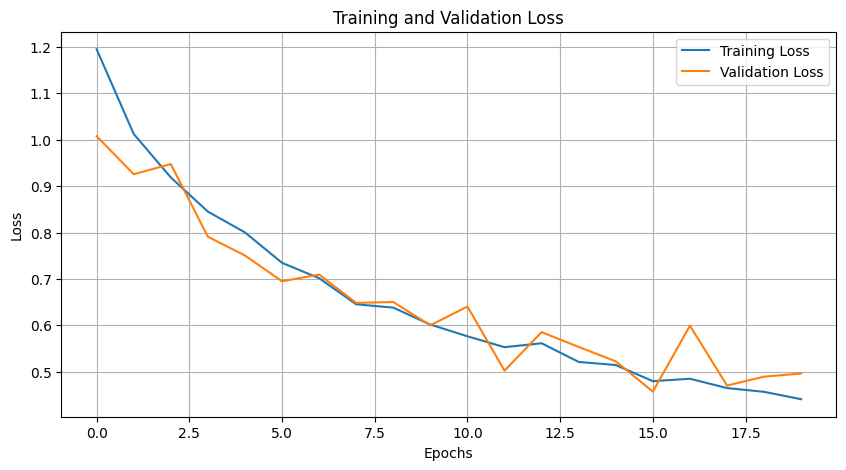

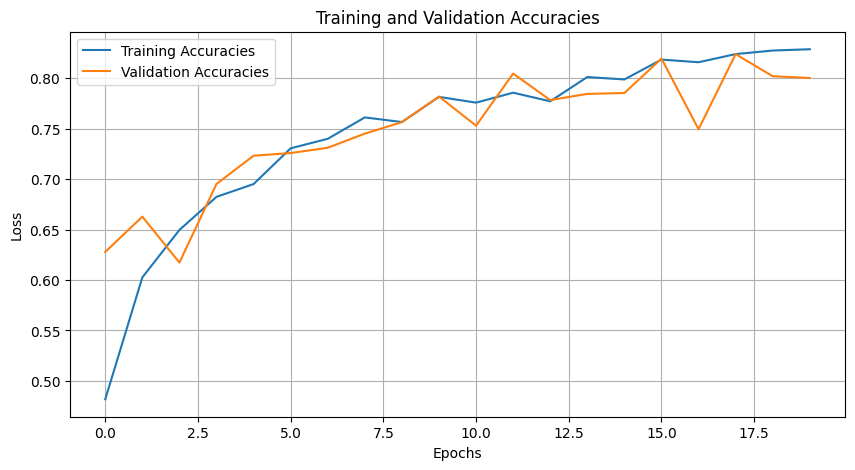

In [19]:
# Plotting Training and Validation Loss

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracies')
plt.plot(val_accuracies, label='Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

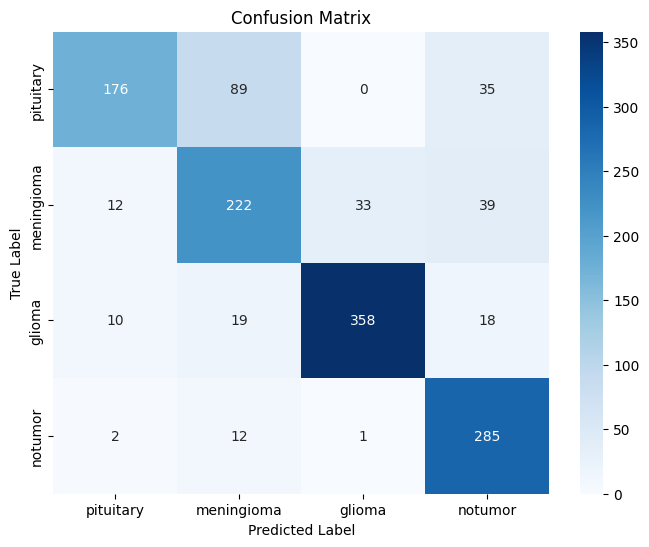

In [20]:
# Compute confusion matrix for test set
cm = confusion_matrix(all_labels, all_preds)
class_names = [name for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 8. Visualize Attention of the Model

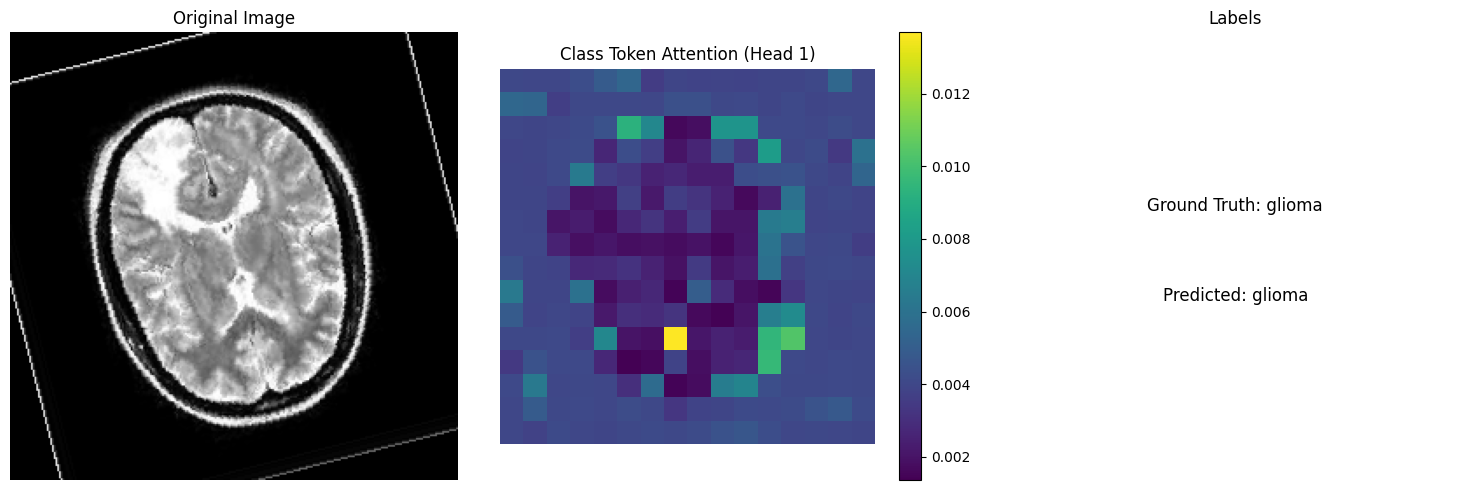

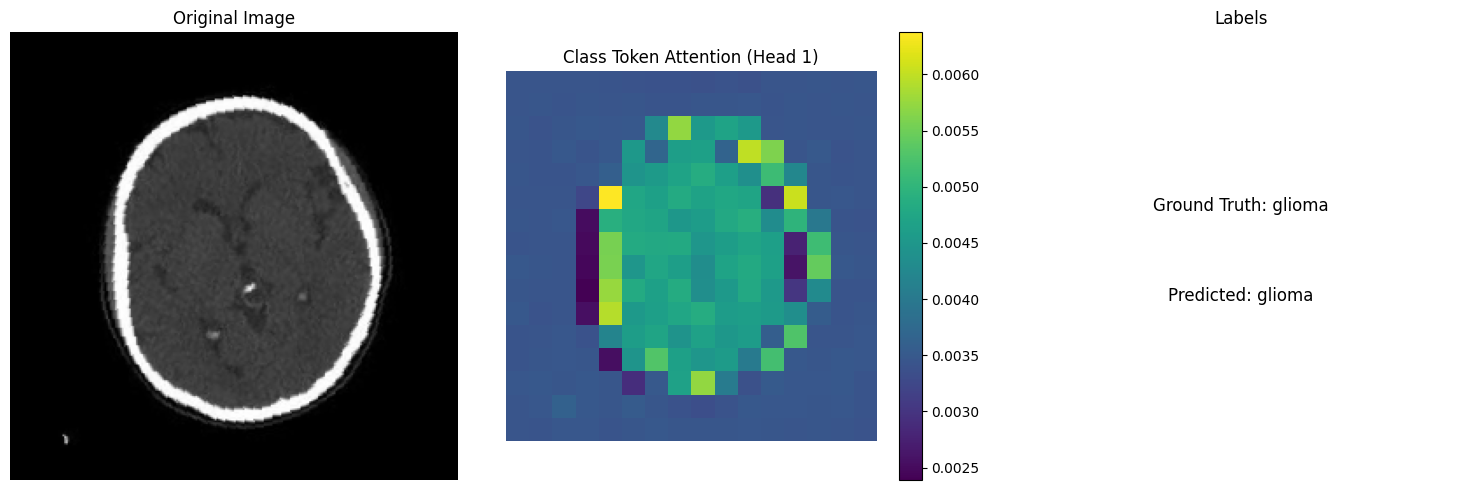

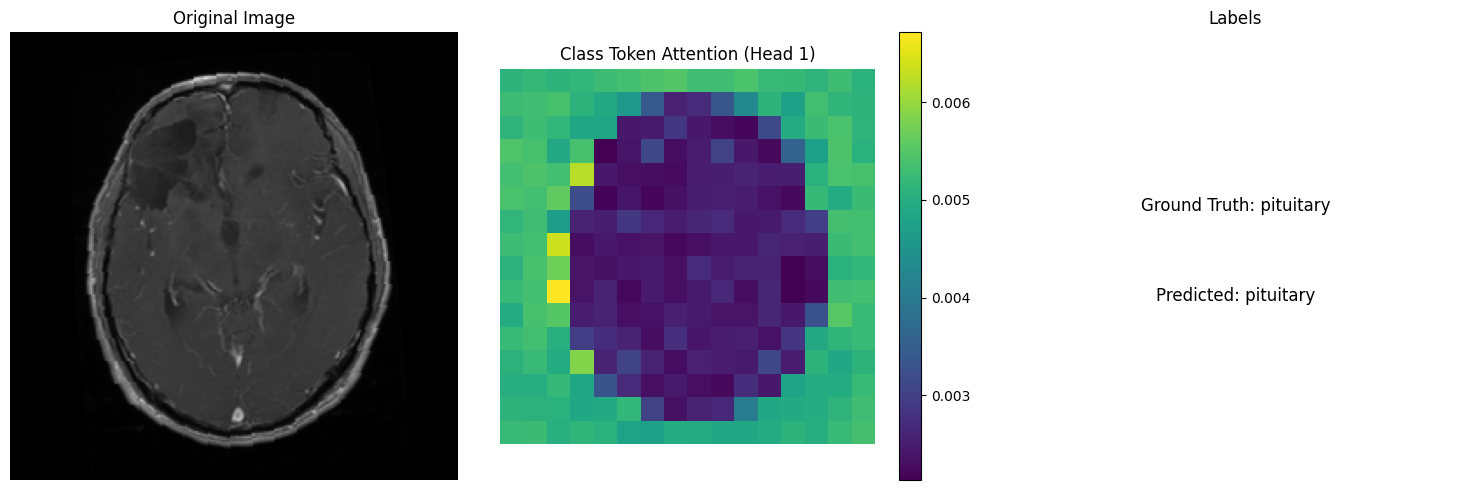

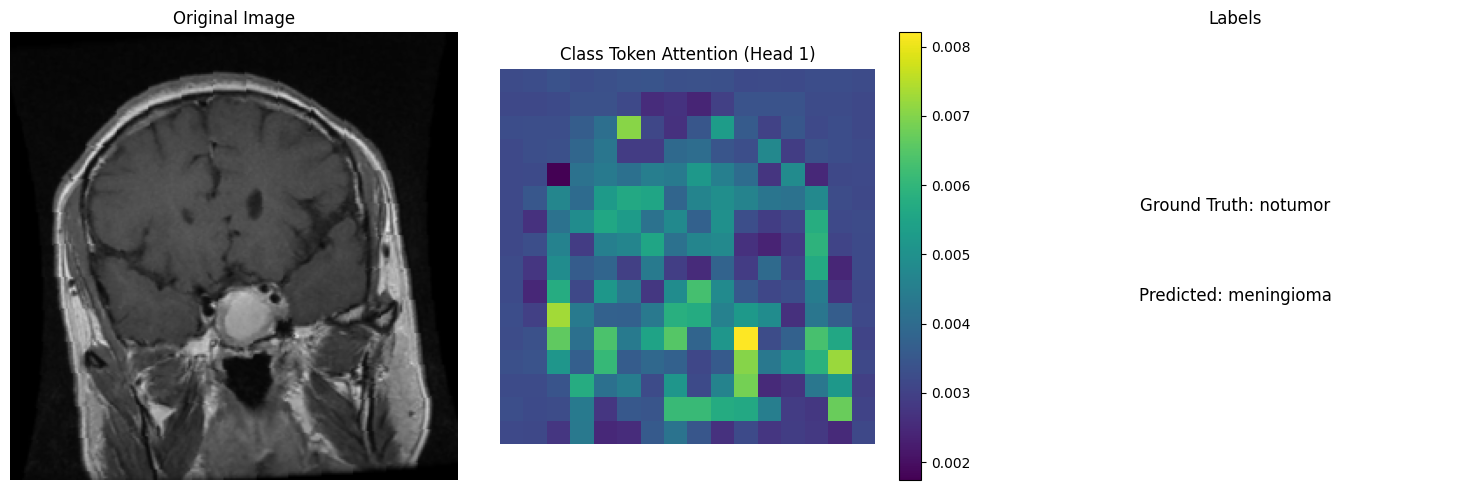

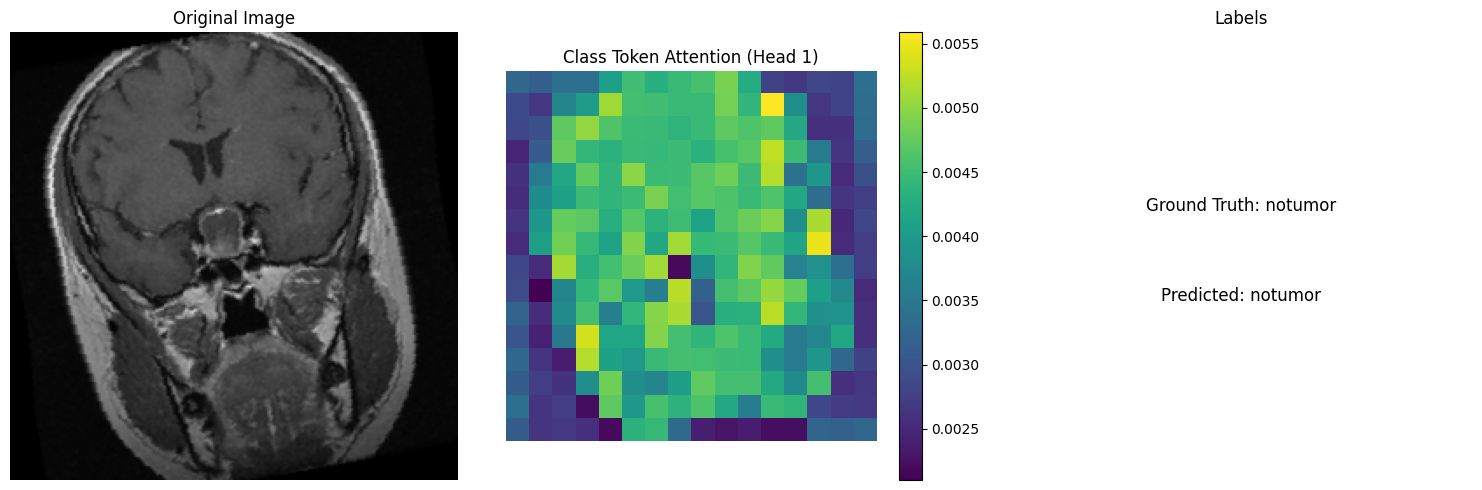

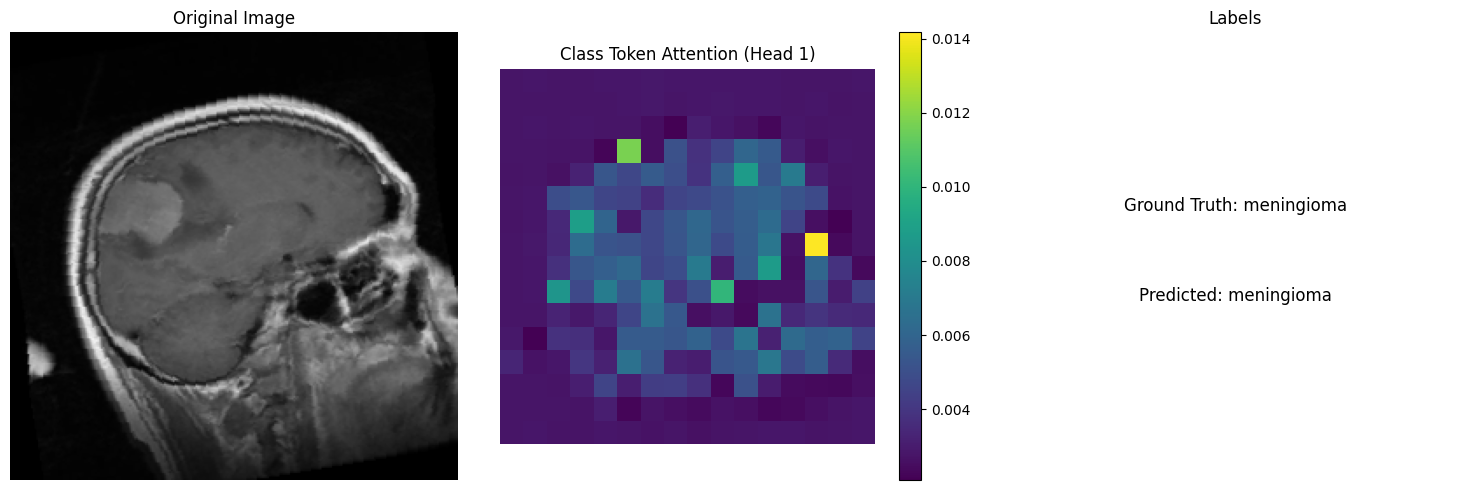

In [28]:
import matplotlib.pyplot as plt
import numpy as np

number = 0

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.cpu().numpy()

        # Get the logits and attention maps
        logits, attn_maps = model(images, return_attn=True)
        _, preds = torch.max(logits, dim=1)
        preds = preds.cpu().numpy()


        selected_layer = -1  # Last layer
        selected_head = 0   # First attention head

        # Get the attention map for the selected layer and head
        attn_map = attn_maps[selected_layer][selected_head]

        # Extract the attention map for the class token (typically the first token)
        class_token_attention = attn_map[0, 1:].detach().cpu().numpy()  # Skip the class token itself

        # Reshape the attention map to 2D (height, width)
        # If the number of patches is a perfect square, we can reshape it into a grid
        num_patches = int(np.sqrt(attn_map.shape[1] - 1))  # Subtract 1 for the class token
        attn_map_2d = class_token_attention.reshape(num_patches, num_patches)

        # Plot the original image and attention map
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot original image
        img_np = images[0].detach().cpu().numpy().transpose(1, 2, 0)
        img_np = np.squeeze(img_np)
        img_np = (img_np + 1) / 2
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Plot the attention map
        im = axes[1].imshow(attn_map_2d, cmap='viridis')
        axes[1].set_title(f'Class Token Attention (Head {selected_head + 1})')
        axes[1].axis('off')

        # Display ground truth and predicted labels
        ground_truth = class_names[labels[0]]  # Get the ground truth label for the first image
        predicted_label = class_names[preds[0]]  # Get the predicted label for the first image
        axes[2].axis('off')
        axes[2].text(0.5, 0.6, f'Ground Truth: {ground_truth}', fontsize=12, ha='center')
        axes[2].text(0.5, 0.4, f'Predicted: {predicted_label}', fontsize=12, ha='center')
        axes[2].set_title('Labels')

        # Add colorbar
        fig.colorbar(im, ax=axes[1])

        plt.tight_layout()
        plt.show()

        number += 1
        if number > 5:
          break
         # Only process the first batch for visualization


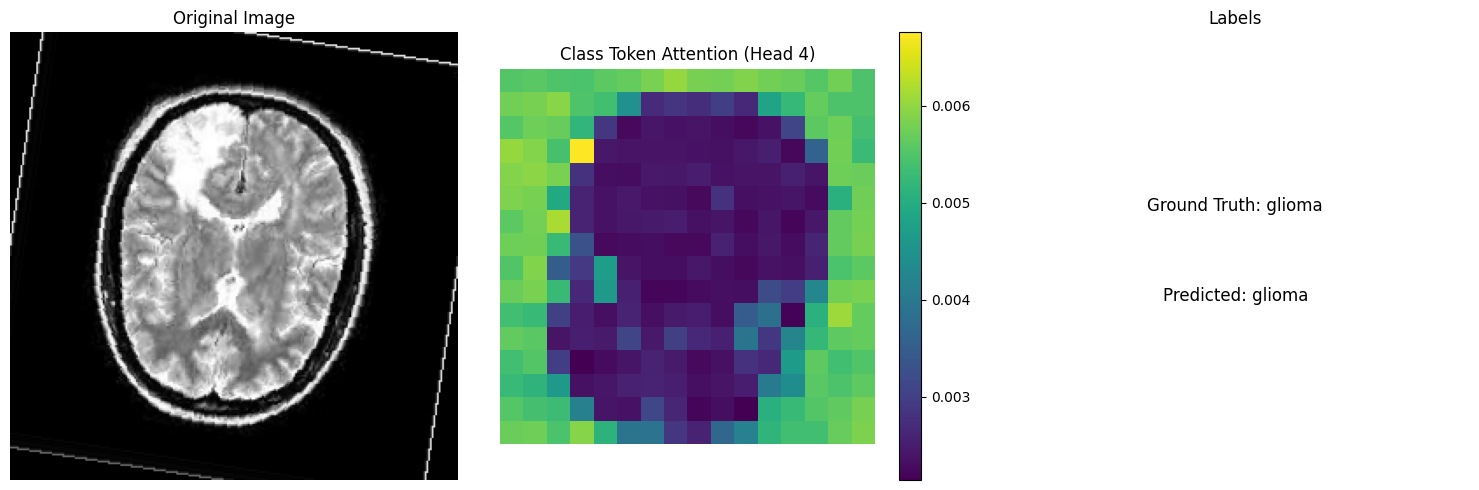

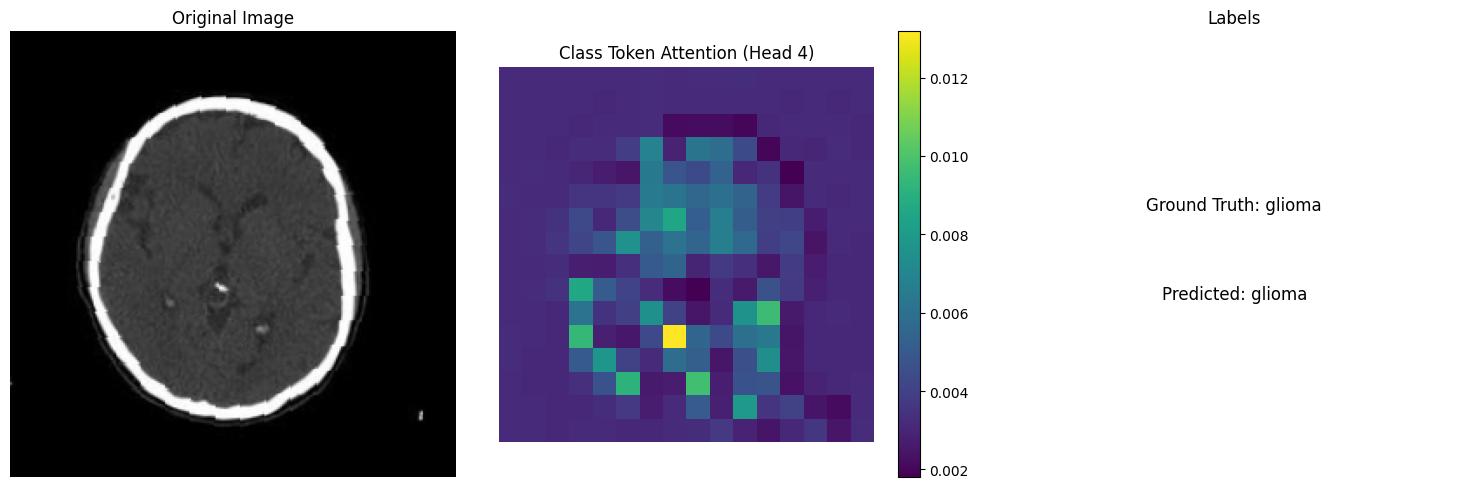

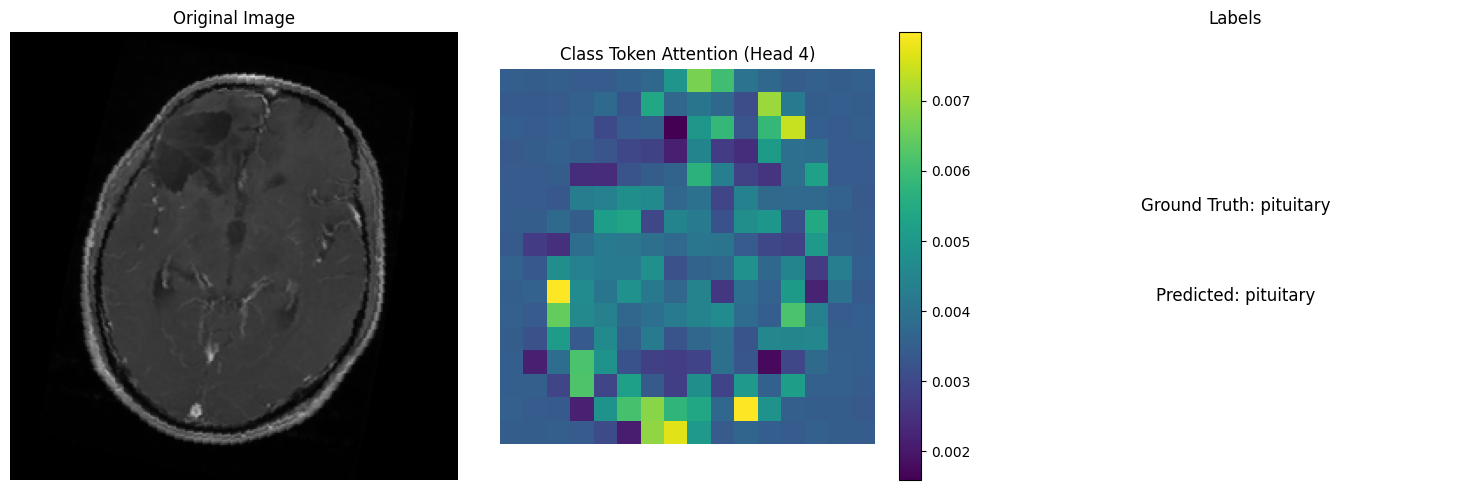

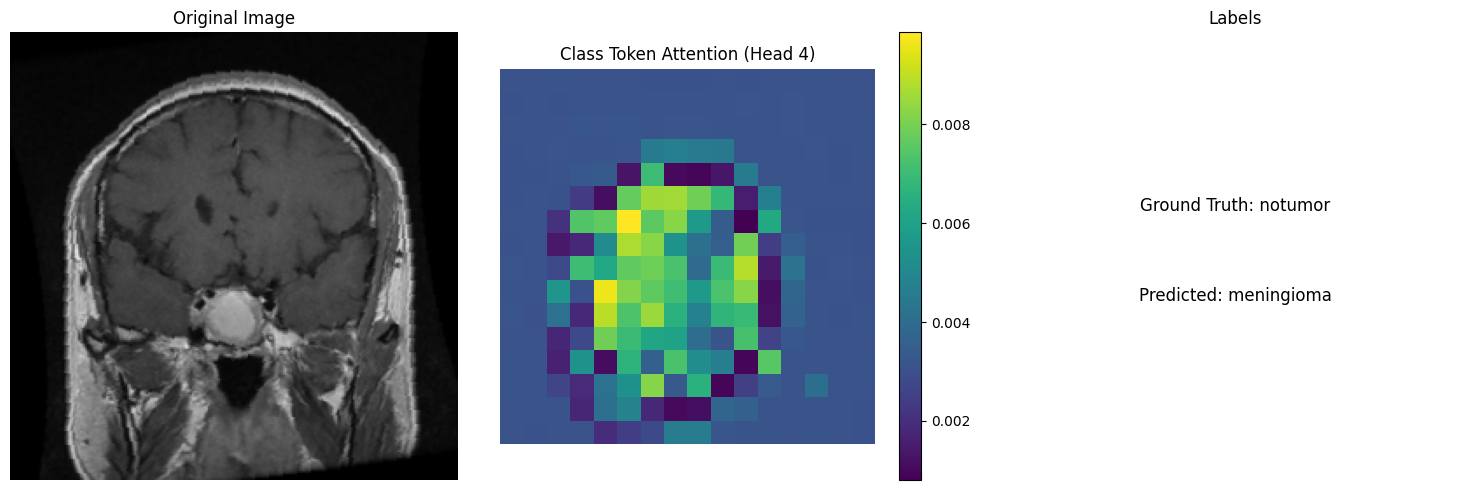

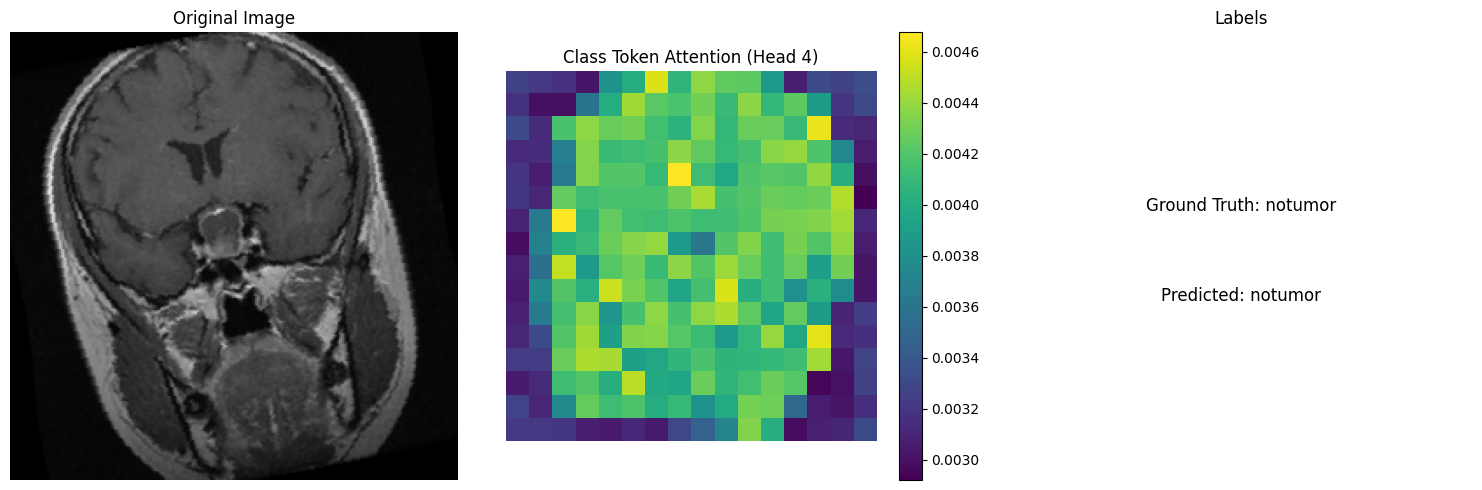

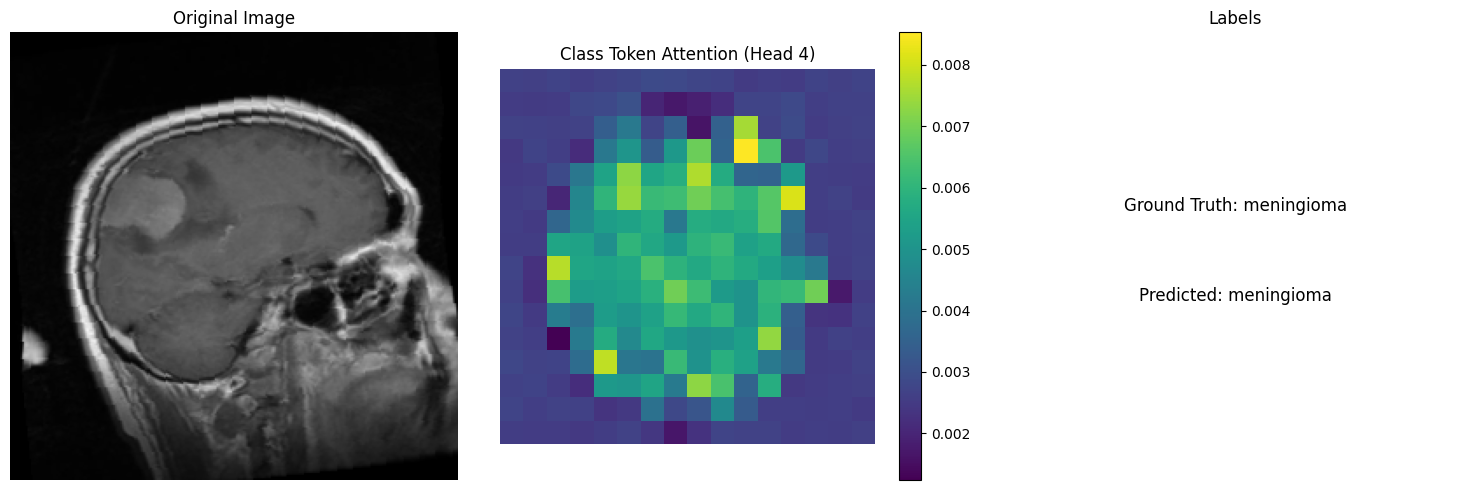

In [32]:
import matplotlib.pyplot as plt
import numpy as np

number = 0

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.cpu().numpy()

        # Get the logits and attention maps
        logits, attn_maps = model(images, return_attn=True)
        _, preds = torch.max(logits, dim=1)
        preds = preds.cpu().numpy()


        selected_layer = -1  # Last layer
        selected_head = 3   # First attention head

        # Get the attention map for the selected layer and head
        attn_map = attn_maps[selected_layer][selected_head]

        # Extract the attention map for the class token (typically the first token)
        class_token_attention = attn_map[0, 1:].detach().cpu().numpy()  # Skip the class token itself

        # Reshape the attention map to 2D (height, width)
        # If the number of patches is a perfect square, we can reshape it into a grid
        num_patches = int(np.sqrt(attn_map.shape[1] - 1))  # Subtract 1 for the class token
        attn_map_2d = class_token_attention.reshape(num_patches, num_patches)

        # Plot the original image and attention map
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot original image
        img_np = images[0].detach().cpu().numpy().transpose(1, 2, 0)
        img_np = np.squeeze(img_np)
        img_np = (img_np + 1) / 2
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Plot the attention map
        im = axes[1].imshow(attn_map_2d, cmap='viridis')
        axes[1].set_title(f'Class Token Attention (Head {selected_head + 1})')
        axes[1].axis('off')

        # Display ground truth and predicted labels
        ground_truth = class_names[labels[0]]  # Get the ground truth label for the first image
        predicted_label = class_names[preds[0]]  # Get the predicted label for the first image
        axes[2].axis('off')
        axes[2].text(0.5, 0.6, f'Ground Truth: {ground_truth}', fontsize=12, ha='center')
        axes[2].text(0.5, 0.4, f'Predicted: {predicted_label}', fontsize=12, ha='center')
        axes[2].set_title('Labels')

        # Add colorbar
        fig.colorbar(im, ax=axes[1])

        plt.tight_layout()
        plt.show()

        number += 1
        if number > 5:
          break
         # Only process the first batch for visualization


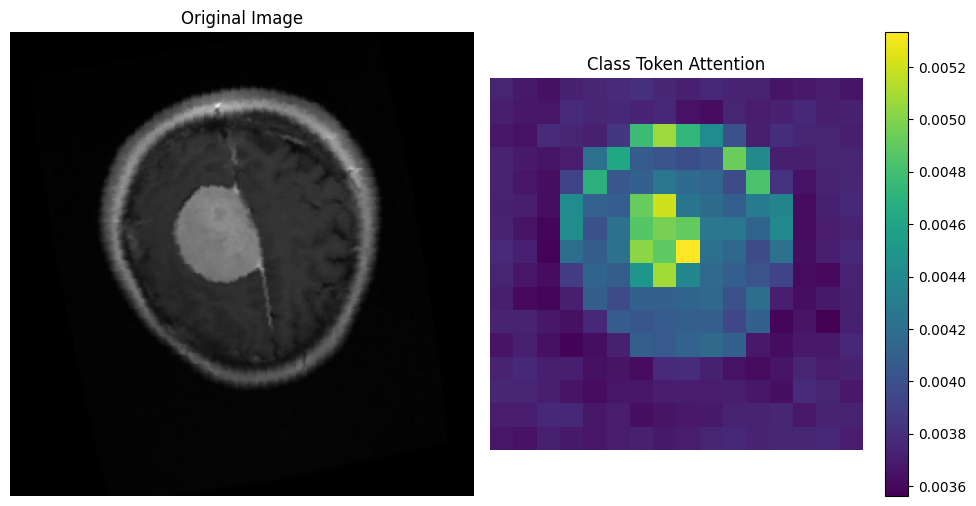

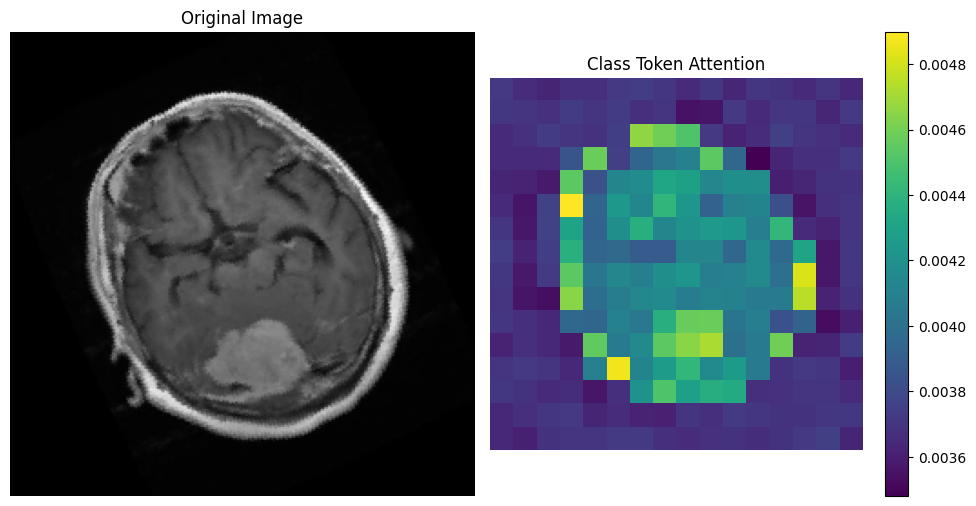

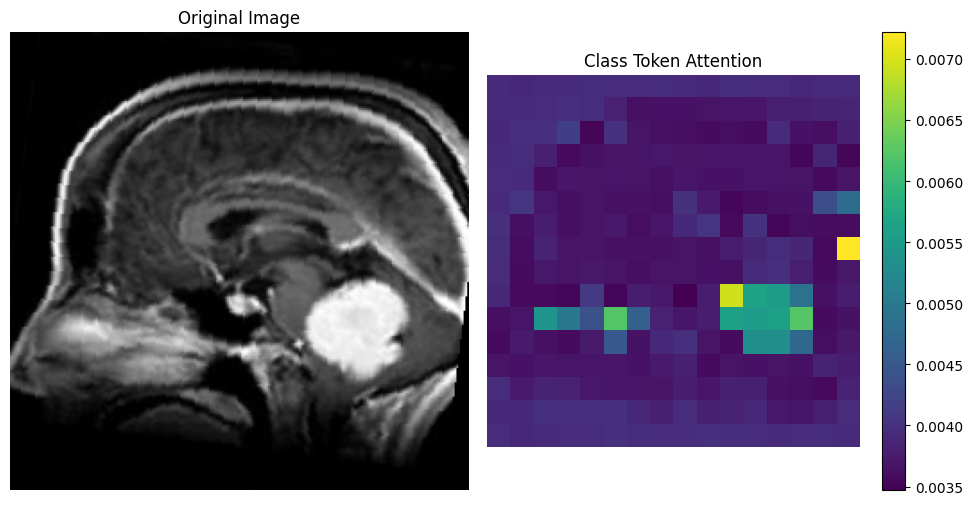

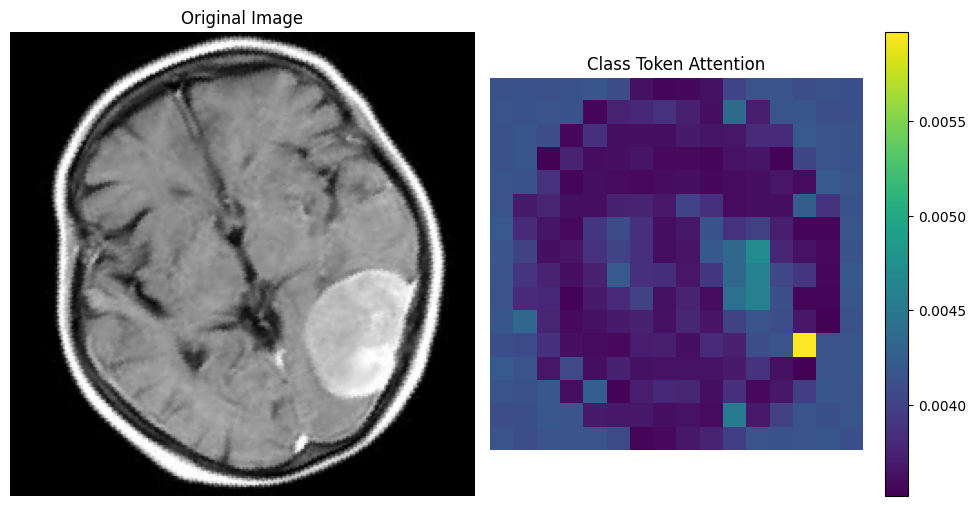

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)

        logits, attn_maps = model(images, return_attn=True)

        ##################################################
        ####################### TODO #####################
        # Compute the 2d attention map for 4 different   #
        # images showing the attention of the model      #
        # on each patch of the image                     #
        ##################################################
        ##################################################

        attn_map_2d = ...

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        img_np = images[0].detach().cpu().numpy().transpose(1,2,0)
        img_np = np.squeeze(img_np)
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        im = axes[1].imshow(attn_map_2d, cmap='viridis')
        axes[1].set_title('Class Token Attention')
        axes[1].axis('off')

        fig.colorbar(im, ax=axes[1])
        plt.tight_layout()
        plt.show()
